In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

# we won't use these packages directly, but the function that picks colors will
import scipy
import scipy.misc
import scipy.cluster

# If you haven't yet, you may need to install scipy
#!conda install -c anaconda scipy


# NOTE: I am not expecting you to know how to write these on your own!
def quantizetopalette(silf, palette, dither=False):
    """Convert an RGB or L mode image to use a given P image's palette."""
    # refs:
    # [1] https://stackoverflow.com/questions/29433243/convert-image-to-specific-palette-using-pil-without-dithering

    silf.load()

    # use palette from reference image
    palette.load()
    if palette.mode != "P":
        raise ValueError("bad mode for palette image")
    if silf.mode != "RGB" and silf.mode != "L":
        raise ValueError(
            "only RGB or L mode images can be quantized to a palette"
            )
    im = silf.im.convert("P", 1 if dither else 0, palette.im)
    # the 0 above means turn OFF dithering

    # Later versions of Pillow (4.x) rename _makeself to _new
    try:
        return silf._new(im)
    except AttributeError:
        return silf._makeself(im)


def convert_image(image, ncolors = 8):
    # refs:
    # [1]: https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image
    image = image.convert('RGB') # can't use alpha channel
    NUM_CLUSTERS = ncolors # unnecessary re-naming
    
    ar = np.array(image) # to data
    
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

    print('finding ' + str(ncolors) + ' most common colors.  Note, if "ncolors" is large, this can take a while...')
    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
    print('Done finding colors! cluster centres in RGB:\n', codes)

    vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = np.histogram(vecs, len(codes))    # count occurrences
    
    # into a 256 palette, integer types
    reds = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,0])).astype('int')
    greens = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,1])).astype('int')
    blues = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,2])).astype('int')

    # palette formatting:
    myPalette = []
    for i in range(256):
        myPalette.extend( (reds[i],greens[i],blues[i]))
        
    palimage = Image.new('P', (16, 16)) # placeholder image
    palimage.putpalette(myPalette)
    newimage = quantizetopalette(image, palimage, dither=False)
    newimage = newimage.convert('RGB')
    return newimage, codes

# similar to above, but allows you to import your own RGB sequence
def convert_image_specific(image, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ]):
    image = image.convert('RGB') # can't use alpha channel
    NUM_CLUSTERS = len(colors) # unnecessary re-naming
    codes = np.array(colors) # unnecessary renaming
    
    # into a 256 palette, integer types
    reds = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,0])).astype('int')
    greens = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,1])).astype('int')
    blues = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,2])).astype('int')

    # palette formatting:
    myPalette = []
    for i in range(256):
        myPalette.extend( (reds[i],greens[i],blues[i]))
        
    palimage = Image.new('P', (16, 16)) # placeholder image
    palimage.putpalette(myPalette)
    newimage = quantizetopalette(image, palimage, dither=False)
    newimage = newimage.convert('RGB')
    return newimage, codes

## Image 1

In [80]:
im1 = Image.open("Black.jpg") 

In [81]:
im_data1= np.array(im1)

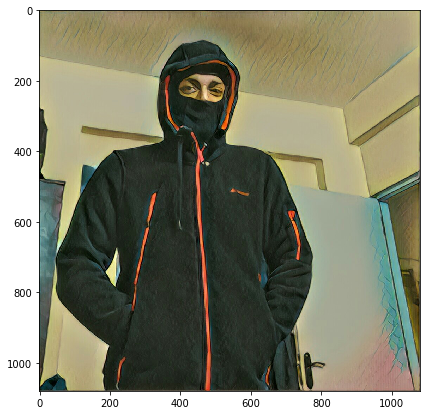

In [82]:
fig, ax = plt.subplots(figsize=(7,7)) 

ax.imshow(im_data1)

plt.show()

In [83]:
new_im1, new_rgbs1 = convert_image(im1, ncolors = 8)

finding 8 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[160.12516523 167.82305976 147.91508307]
 [ 28.05595131  35.0228806   25.5150624 ]
 [174.61397768 158.28334658 118.47834768]
 [ 42.05410555  51.30247608  42.60243049]
 [100.02484655  92.95359212  65.00669145]
 [151.45844579 135.77217349  93.05837957]
 [189.01171815 183.72921807 142.91218299]
 [102.34821524 151.67209776 144.45594383]]


In [84]:
new_im_data1= np.array(new_im1)

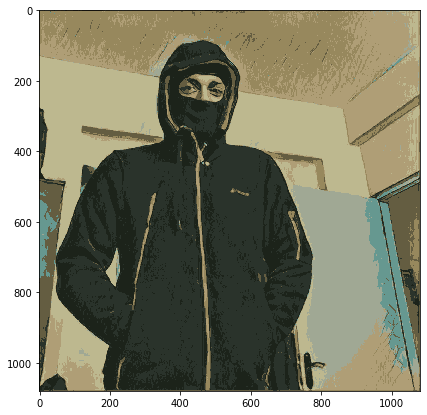

In [85]:
fig, ax = plt.subplots(figsize=(7,7)) 

ax.imshow(new_im_data1)

plt.show()


In [86]:
unique_color_array1=np.unique(new_im_data1.reshape(-1, new_im_data1.shape[2]), axis=0)
unique_color_array1

array([[ 28,  35,  26],
       [ 42,  51,  43],
       [100,  93,  65],
       [102, 152, 144],
       [151, 136,  93],
       [160, 168, 148],
       [175, 158, 118],
       [189, 184, 143]], dtype=uint8)

In [87]:
number_of_pixels_of_a_color1 = [] 
color_labels1 = []
colors1 = []
for icolor1,rgba1 in enumerate(unique_color_array1):
  
    
    # pixel masking
    reds_mask1 = new_im_data1[:,:,0] == rgba1[0]
    greens_mask1 = new_im_data1[:,:,1] == rgba1[1]
    blues_mask1 = new_im_data1[:,:,2] == rgba1[2]
    pixel_mask1 = reds_mask1 & greens_mask1 & blues_mask1
    
    # pixels count
    this_color_pixels1 = new_im_data1[pixel_mask1]
    number_of_pixels_of_a_color1.append(len(this_color_pixels1))
    
    #color labelling
    color_labels1.append( 'Color #' + str(icolor1) )
    
    colors1.append( rgba1/255 )

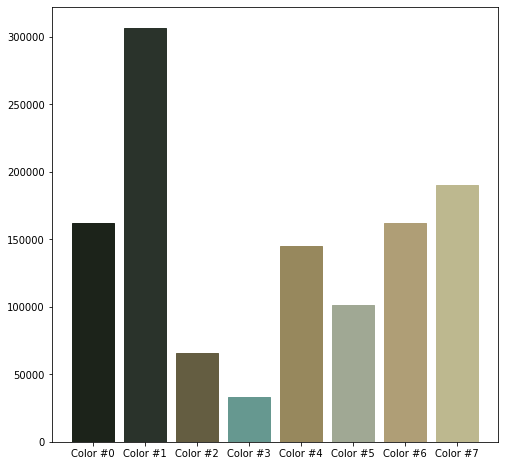

In [88]:
fig, ax = plt.subplots(figsize=(8,8))

myBarChart1 = ax.bar(color_labels1, number_of_pixels_of_a_color1) 
# set colors for each bar individually
for i in range(len(myBarChart1)):
    myBarChart1[i].set_color(colors1[i])
    
plt.show()

In [119]:
same_new_im1, same_new_rgbs1 = convert_image_specific(im1, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ])

r_new_im_data1= np.array(same_new_im1)


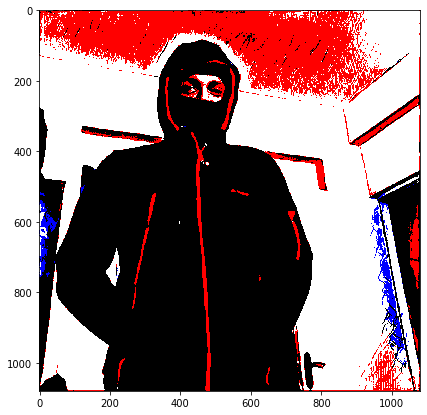

In [120]:
fig, ax = plt.subplots(figsize=(7,7)) 

ax.imshow(r_new_im_data1)

plt.show()

In [121]:
unique_color_array1b=np.unique(r_new_im_data1.reshape(-1, r_new_im_data1.shape[2]), axis=0)
unique_color_array1b

array([[  0,   0,   0],
       [  0,   0, 255],
       [255,   0,   0],
       [255, 255, 255]], dtype=uint8)

In [122]:
number_of_pixels_of_a_color1b = [] 
color_labels1b = []
colors1b = []
for icolor1b,rgba1b in enumerate(unique_color_array1b):
  
    
    # pixel masking
    reds_mask1b = r_new_im_data1[:,:,0] == rgba1b[0]
    greens_mask1b = r_new_im_data1[:,:,1] == rgba1b[1]
    blues_mask1b = r_new_im_data1[:,:,2] == rgba1b[2]
    pixel_mask1b = reds_mask1b & greens_mask1b & blues_mask1b
    
    # pixels count
    this_color_pixels1b = r_new_im_data1[pixel_mask1b]
    number_of_pixels_of_a_color1b.append(len(this_color_pixels1b))
    
    #color labelling
    color_labels1b.append( 'Color #' + str(icolor1b) )
    
    colors1b.append( rgba1b/255 )

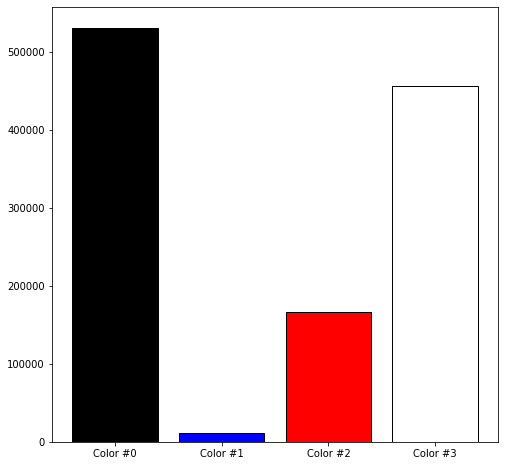

In [139]:
fig, ax = plt.subplots(figsize=(8,8))

myBarChart1b = ax.bar(color_labels1b, number_of_pixels_of_a_color1b) 
# set colors for each bar individually
for i in range(len(myBarChart1b)):
    myBarChart1b[i].set_color(colors1b[i])
    myBarChart1b[i].set_edgecolor('black') # because one of our colors is white
    myBarChart1b[i].set_linewidth(1)
    
plt.show()

## Image 2

In [89]:
im2 = Image.open("Landscape.jpg") 

In [90]:
im_data2= np.array(im2)

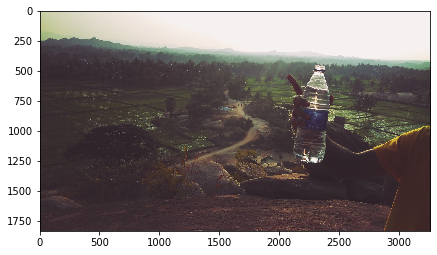

In [91]:
fig, ax = plt.subplots(figsize=(7,7)) 

ax.imshow(im_data2)

plt.show()

In [92]:
new_im2, new_rgbs2 = convert_image(im2, ncolors = 8)

finding 8 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[208.81221651 209.35352731 190.74840895]
 [ 53.56230989  40.09082972  44.03810259]
 [ 75.95683417  62.99704113  61.5581614 ]
 [114.52744515 116.93708469  94.88265101]
 [157.61898232 172.98320368 142.83564219]
 [ 63.59804398  49.96034383  52.45936044]
 [ 91.07206104  84.68706993  77.42360354]
 [243.84771662 238.6366993  236.17114996]]


In [93]:
new_im_data2= np.array(new_im2)

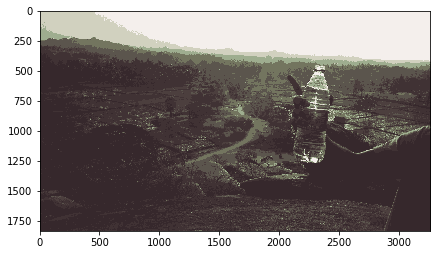

In [94]:
fig, ax = plt.subplots(figsize=(7,7)) 

ax.imshow(new_im_data2)

plt.show()


In [95]:
unique_color_array2=np.unique(new_im_data2.reshape(-1, new_im_data2.shape[2]), axis=0)
unique_color_array2

array([[ 54,  40,  44],
       [ 64,  50,  52],
       [ 76,  63,  62],
       [ 91,  85,  77],
       [115, 117,  95],
       [158, 173, 143],
       [209, 209, 191],
       [244, 239, 236]], dtype=uint8)

In [96]:
number_of_pixels_of_a_color2 = [] 
color_labels2 = []
colors2 = []
for icolor2,rgba2 in enumerate(unique_color_array2):
  
    
    # pixel masking
    reds_mask2 = new_im_data2[:,:,0] == rgba2[0]
    greens_mask2 = new_im_data2[:,:,1] == rgba2[1]
    blues_mask2 = new_im_data2[:,:,2] == rgba2[2]
    pixel_mask2 = reds_mask2 & greens_mask2 & blues_mask2
    
    # pixels count
    this_color_pixels2 = new_im_data2[pixel_mask2]
    number_of_pixels_of_a_color2.append(len(this_color_pixels2))
    
    #color labelling
    color_labels2.append( 'Color #' + str(icolor2) )
    
    colors2.append( rgba2/255 )

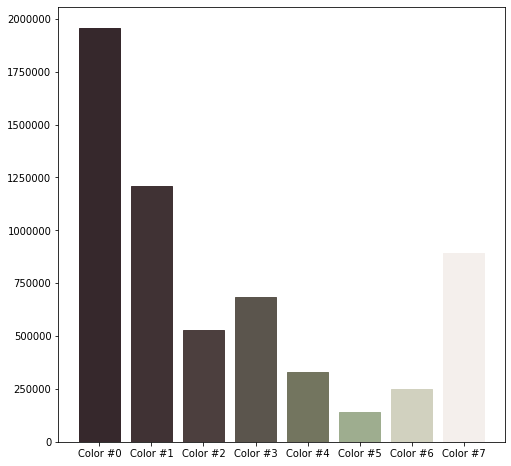

In [97]:
fig, ax = plt.subplots(figsize=(8,8))

myBarChart2 = ax.bar(color_labels2, number_of_pixels_of_a_color2) 
# set colors for each bar individually
for i in range(len(myBarChart2)):
    myBarChart2[i].set_color(colors2[i])
    
plt.show()

In [124]:
same_new_im2, same_new_rgbs1 = convert_image_specific(im2, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ])

r_new_im_data2= np.array(same_new_im2)

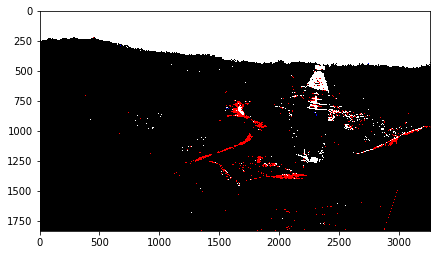

In [125]:
fig, ax = plt.subplots(figsize=(7,7)) 

ax.imshow(r_new_im_data2)

plt.show()

In [126]:
unique_color_array2b=np.unique(r_new_im_data2.reshape(-1, r_new_im_data2.shape[2]), axis=0)
unique_color_array2b

array([[  0,   0,   0],
       [  0,   0, 255],
       [255,   0,   0],
       [255, 255, 255]], dtype=uint8)

In [127]:
number_of_pixels_of_a_color2b = [] 
color_labels2b = []
colors2b = []
for icolor2b,rgba2b in enumerate(unique_color_array2b):
  
    
    # pixel masking
    reds_mask2b = r_new_im_data2[:,:,0] == rgba2b[0]
    greens_mask2b = r_new_im_data2[:,:,1] == rgba2b[1]
    blues_mask2b = r_new_im_data2[:,:,2] == rgba2b[2]
    pixel_mask2b = reds_mask2b & greens_mask2b & blues_mask2b
    
    # pixels count
    this_color_pixels2b = r_new_im_data2[pixel_mask2b]
    number_of_pixels_of_a_color2b.append(len(this_color_pixels2b))
    
    #color labelling
    color_labels2b.append( 'Color #' + str(icolor2b) )
    
    colors2b.append( rgba2b/255 )

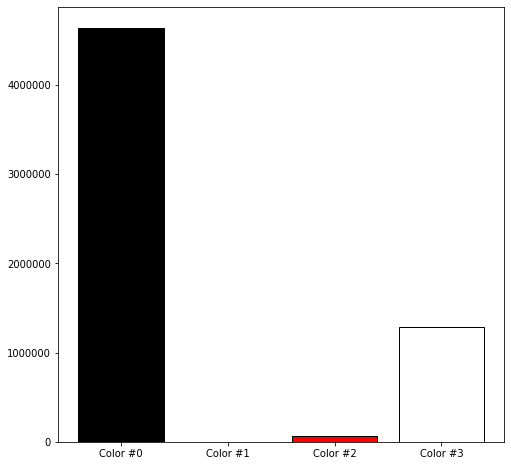

In [138]:
fig, ax = plt.subplots(figsize=(8,8))

myBarChart2b = ax.bar(color_labels2b, number_of_pixels_of_a_color2b) 
# set colors for each bar individually
for i in range(len(myBarChart2b)):
    myBarChart2b[i].set_color(colors2b[i])
    myBarChart2b[i].set_edgecolor('black') # because one of our colors is white
    myBarChart2b[i].set_linewidth(1)
    
plt.show()

## Image 3

In [102]:
im3 = Image.open("Cat.jfif") 

In [103]:
im_data3= np.array(im3)

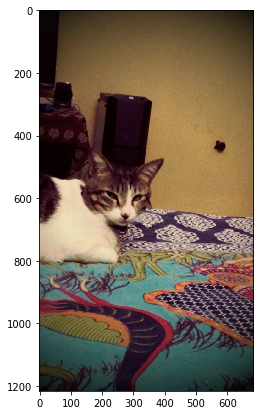

In [104]:
fig, ax = plt.subplots(figsize=(7,7)) 

ax.imshow(im_data3)

plt.show()

In [105]:
new_im3, new_rgbs3 = convert_image(im3, ncolors = 8)

finding 8 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[ 22.31256749   5.96819333  11.90642213]
 [ 53.67274123  36.91258055  41.36047242]
 [134.41911969 102.88161165  67.90560854]
 [ 98.79369844  68.37252538  51.74013023]
 [171.6136183  134.86685955  82.67692182]
 [118.70819604 137.45496076 133.41061395]
 [216.99367536 195.34054507 168.32293463]
 [ 51.25613954  79.71131953  78.48421067]]


In [106]:
new_im_data3= np.array(new_im3)

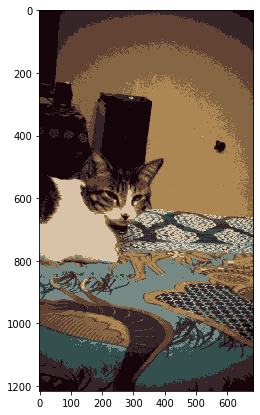

In [107]:
fig, ax = plt.subplots(figsize=(7,7)) 

ax.imshow(new_im_data3)

plt.show()

In [108]:
unique_color_array3=np.unique(new_im_data3.reshape(-1, new_im_data3.shape[2]), axis=0)
unique_color_array3

array([[ 22,   6,  12],
       [ 51,  80,  78],
       [ 54,  37,  41],
       [ 99,  68,  52],
       [119, 137, 133],
       [134, 103,  68],
       [172, 135,  83],
       [217, 195, 168]], dtype=uint8)

In [109]:
number_of_pixels_of_a_color3 = [] 
color_labels3 = []
colors3 = []
for icolor3,rgba3 in enumerate(unique_color_array3):
  
    
    # pixel masking
    reds_mask3 = new_im_data3[:,:,0] == rgba3[0]
    greens_mask3 = new_im_data3[:,:,1] == rgba3[1]
    blues_mask3 = new_im_data3[:,:,2] == rgba3[2]
    pixel_mask3 = reds_mask3 & greens_mask3 & blues_mask3
    
    # pixels count
    this_color_pixels3 = new_im_data3[pixel_mask3]
    number_of_pixels_of_a_color3.append(len(this_color_pixels3))
    
    #color labelling
    color_labels3.append( 'Color #' + str(icolor3) )
    
    colors3.append( rgba3/255 )

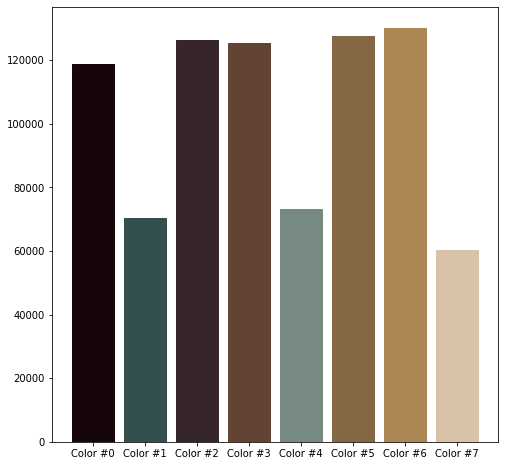

In [110]:
fig, ax = plt.subplots(figsize=(8,8))

myBarChart3 = ax.bar(color_labels3, number_of_pixels_of_a_color3) 
# set colors for each bar individually
for i in range(len(myBarChart3)):
    myBarChart3[i].set_color(colors3[i])
    
plt.show()

In [129]:
same_new_im3, same_new_rgbs3 = convert_image_specific(im3, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ])

r_new_im_data3= np.array(same_new_im3)

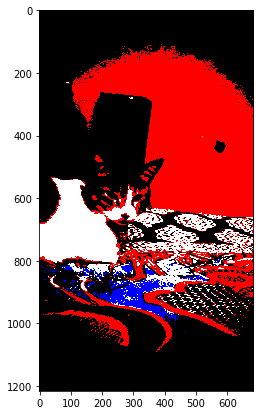

In [130]:
fig, ax = plt.subplots(figsize=(7,7)) 

ax.imshow(r_new_im_data3)

plt.show()

In [131]:
unique_color_array3b=np.unique(r_new_im_data3.reshape(-1, r_new_im_data3.shape[2]), axis=0)
unique_color_array3b

array([[  0,   0,   0],
       [  0,   0, 255],
       [255,   0,   0],
       [255, 255, 255]], dtype=uint8)

In [132]:
number_of_pixels_of_a_color3b = [] 
color_labels3b = []
colors3b = []
for icolor3b,rgba3b in enumerate(unique_color_array3b):
  
    
    # pixel masking
    reds_mask3b = r_new_im_data3[:,:,0] == rgba3b[0]
    greens_mask3b = r_new_im_data3[:,:,1] == rgba3b[1]
    blues_mask3b = r_new_im_data3[:,:,2] == rgba3b[2]
    pixel_mask3b = reds_mask3b & greens_mask3b & blues_mask3b
    
    # pixels count
    this_color_pixels3b = r_new_im_data3[pixel_mask3b]
    number_of_pixels_of_a_color3b.append(len(this_color_pixels3b))
    
    #color labelling
    color_labels3b.append( 'Color #' + str(icolor3b) )
    
    colors3b.append( rgba3b/255 )

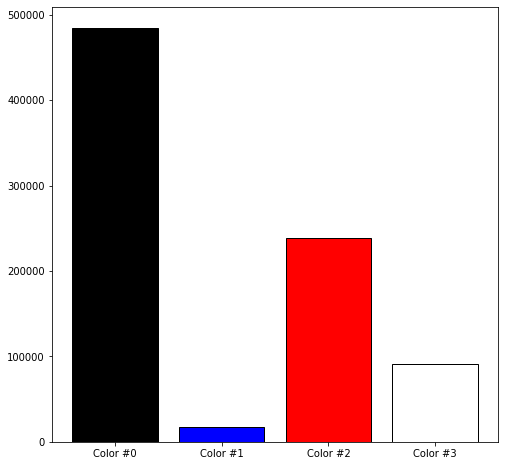

In [137]:
fig, ax = plt.subplots(figsize=(8,8))

myBarChart3b = ax.bar(color_labels3b, number_of_pixels_of_a_color3b) 
# set colors for each bar individually
for i in range(len(myBarChart3b)):
    myBarChart3b[i].set_color(colors3b[i])
    myBarChart3b[i].set_edgecolor('black') # because one of our colors is white
    myBarChart3b[i].set_linewidth(1)
plt.show()